In [2]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.visualization import plot_histogram, plot_state_qsphere
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Grover's algorithm

### What is it made for ?
Grover's algorithm is made to find a value that responds to a certain criterion in a list of values. 

For example, lets take a list L of the first 10 numbers : 
$$L = [0,1,2,3,4,5,6,7,8,9]$$
And say that we are looking to get the number 7, that will be called the winner and noted $w$ from now on. Grover's algorithm allows you to find $w$, but way faster than the classical approach of scanning the list to find the answer.

### Briefly, how is it made ?
An iteration of Grover's algorithm is decomposed in 2 parts : <br/>
1. The oracle : the goal of the oracle is to determine which input is the winner. Usually, the oracle is made after considering how to translate the real world oracle in the quantum world. After applying the oracle to the circuit, the resulting state will be the same as the input, but with the winner's phase changed to $-\frac{\pi}{2}$
2. The amplification : after determining the winner, we want the final state of our quantum circuit to be the winner's state. To find it, we use a rotation (composed of two reflections) to make the state we find at the output of the oracle physically closer to the winner's state.

### Making an oracle
Lets take a simple example to really understand how Grover's algorithm works : 
We take the following circuit that constructs the basis of a two-qubit quantum circuit. The following circuit construct the state $\frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle$, which is the superposition we want to look for our winner in.

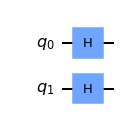

In [3]:
qc = QuantumCircuit(2) # Initialize our circuit with two quantum registers
qc.h(range(2))         # Apply the hadamard gate to qubit 0 and 1
qc.draw(output = 'mpl')

With the help of the statevector simulator, we an check that the state builded is indeed the basis of a two qubits problem :

In [4]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
initial = result.get_statevector()
initial.draw(output = 'latex')

<IPython.core.display.Latex object>

We just constructed a representation of the list : 
$$[|00\rangle,|01〉,|10〉,|11〉]$$
Say that one wants to look if the value |11〉exists in the list above.
One have to write the oracle below to find the winner :

In [5]:
def simple_oracle():
    qc = QuantumCircuit(2, name = 'simple_oracle') #We create a quantum circuit with two quantum register as the winner is encoded on two classical bits
    qc.cz(0,1)                                     #We choose the cz gate for the reason detailled below
    return qc.to_gate()                            #We return a usable gate to append at the end of our already existing circuit

How does this oracle works and why does it change the phase of the winner ?
Our goal is to change our input state vector described above to 
    $$\frac{1}{2}( |00〉+|01〉+|10〉+|11〉) \stackrel{oracle}{=} \frac{1}{2} ( |00〉+|01〉+|10〉-|11〉)$$
    
And its precisely what our oracle circuit defined above does :
We have as input :
$$
\frac{1}{2}( |00〉+|01〉+|10〉+|11〉) = 
\begin{pmatrix}
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}
\end{pmatrix}
$$
and we apply the cz operator to it : 
$$
\stackrel{CZ}{
\begin{pmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&1&0\\
0&0&0&-1
\end{pmatrix}}\\
\begin{pmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&1&0\\
0&0&0&-1
\end{pmatrix} . 
\begin{pmatrix}
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}
\end{pmatrix} = 
\begin{pmatrix}
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}\\
-\frac{1}{2}
\end{pmatrix} = 
\frac{1}{2} ( |00〉+|01〉+|10〉-|11〉)
$$
Lets apply it :

In [6]:
qc.append(simple_oracle(), range(2)) # We add the gate constructed by our simple_oracle function at the end of our circuit

Lets measure it again to check that we have the right state : 

In [7]:
job = execute(qc, backend)
result = job.result()
after_oracle = result.get_statevector()
display(after_oracle.draw(output = 'latex'))
print("Measurement results : ")
print(result.get_counts())

<IPython.core.display.Latex object>

Measurement results : 
{'00': 0.25, '01': 0.25, '10': 0.25, '11': 0.25}


In comparison, the oracle we have just created is the equivalent to create a Python function that for every bitstring that you give it, checks wether or not it is equal to the bitstring '11'.

### Understanding the amplification
As we can see, we constructed the right state vector, but when mesuring it, we cannot determine which output is the right one. Thats where the amplification part is used.

To understand how we will amplify our winner qubit's phase to the point where the other qubit's phases will be close to 0, we first need to understand what our oracle performs geometrically.
We can picture the Grover problem in a X-Y plane. Along the +Y axis lives our vector $w$ (which to simplify will have its norm set to 1).
Along the +X axis lives a vector $s'$, orthogonal to $w$.
Our initial state (that we built at the beginning of the oracle part of this notebook) is represented by the vector $s$.

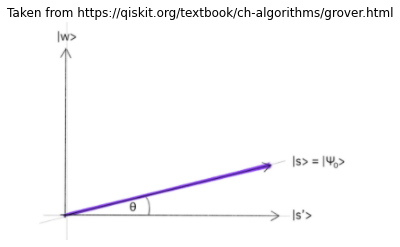

In [5]:
img = mpimg.imread('grover_ressource/grover_initial.png')
plt.axis('off')
plt.title('Taken from https://qiskit.org/textbook/ch-algorithms/grover.html')
plt.imshow(img)

Applying our oracle to the vector $s$ performs a reflection of $s$ around the axis $s'$, as seen below : 

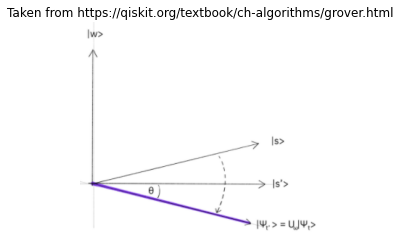

In [6]:
img = mpimg.imread('grover_ressource/grover_first_rotation.png')
plt.axis('off')
plt.title('Taken from https://qiskit.org/textbook/ch-algorithms/grover.html')
plt.imshow(img)

After applying the oracle's reflection, we want to get our new vector closer to the winner vector.
Thus, we apply another reflection defined as follow : 
$$U_s = 2|s\rangle\langle s|-1$$
Thus we have the following vector : 

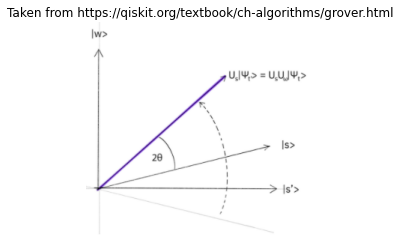

In [7]:
img = mpimg.imread('grover_ressource/grover_last_rotation.png')
plt.axis('off')
plt.title('Taken from https://qiskit.org/textbook/ch-algorithms/grover.html')
plt.imshow(img)

As the vector our vector $s$ as been rotated closer to the winner vector, we have better chance of measuring it.
The operation of applying the oracle and the reflection gate should be repeated $\sqrt{N}$ times, with $N$ the amount of qubits.

### Making the reflection gate
Now that we have understood how the reflection gate should be used, we can make it, for our example :

In [8]:
def reflection():
    qc = QuantumCircuit(2,name = 'reflection')
    qc.h(range(2))
    qc.x(range(2))
    qc.cz(0,1)
    qc.x(range(2))
    qc.h(range(2))
    return qc.to_gate()

We only have to apply our oracle

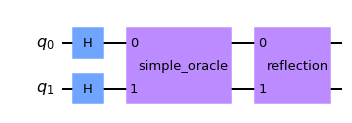

In [9]:
qc.append(reflection(),range(2))
qc.draw(output = 'mpl')

In [10]:
job = execute(qc,backend)
result = job.result()
print(np.around(result.get_statevector()))
print(result.get_counts())

[ 0.+0.j  0.-0.j  0.-0.j -1.-0.j]
{'11': 1.0}


The measurement gives us the right output.

# A concrete use case with Qiskit's syntax

In [3]:
from qiskit import Aer,execute, QuantumCircuit
from qiskit.algorithms import Grover,AmplificationProblem
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
import qiskit.tools.jupyter

### What spice to use
Eric wants to season its pasta plates and has a lot of spices in its kitchen. As Eric has the access to a quantum computer, he decides to input all of his requirements to Grover's algorithm for it to output the best seasoning for its pasta.

In his kitchen, Eric has : 

Seasoning | Spicy ? (c1) | Sweet ? (c2) | Salty ? (c3) | Dry ? (c4) | Bad nutritional score ? (c5) | Encoding
:-:|:-:|:-:|:-:|:-:|:-:|:-:
 Ketchup | no | yes | yes | no | yes | \|$01101\rangle$
 Soy sauce | no | no | yes | no | no | \|$00100\rangle$
 Chili paste | yes | no | yes | yes | no | \|$10110\rangle$
 Heavy cream | no | no | no | no | yes | \|$00001\rangle$
 Dry pasta seasoning | yes | no | no | yes | no | \|$10010\rangle$

Now say that Eric wants the following seasoning for its lunch:
Non-spicy, Salty, already liquid , with a good nutritional score.
Eric can then encode its desire in the following binary expression : 
$\neg c1 \wedge \neg c2 \wedge c3 \wedge \neg c4 \wedge \neg c5$

Thanks to Qiskit's circuit library, in which lives the PhaseOracle class, we can easily transform this boolean expression in an oracle : 

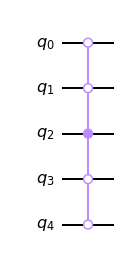

In [52]:
expr = "~c1&~c2&c3&~c4&~c5"
oracle = PhaseOracle(expr)
oracle.draw(output = 'mpl')

Now that we have the oracle part, Qiskit's algorithms library let us create the amplification part easily, thanks to the AmplificationProblem class. 


In [ ]:
problem = AmplificationProblem(oracle,is_good_state=oracle.evaluate_bitstring)# We setup our amplification problem with the oracle and we tell the created object which state is a winner state according to the oracle

We can then bring everything together using the Grover class and the amplify method of a Grover object

In [54]:
backend = Aer.get_backend('qasm_simulator')
algorithm = Grover(quantum_instance=QuantumInstance(backend, shots = 1024))#We setup our grover object that will execute our problem
result = algorithm.amplify(problem)#We execute Grover's algorithm on our amplification problem. The number of iterations is determined in the function amplify
result.top_measurement[::-1]#We reverse the bitstring as Qiskit's measurement are in the wrong order

'00100'

We make a function to determine if the found sauce exists in our list, or if Eric's demand is not feasible

In [61]:
def the_sauce(result):
    season_dict = {'01101':'Ketchup', '00100' : 'Soy Sauce', '10110' : 'Chili paste', '00001' : 'Heavy cream','10010' : 'Dry pasta seasoning'}
    res = season_dict.get(result.top_measurement[::-1])
    if res is not None : 
        return res
    else:
        print("The sauce with the code ",result.top_measurement[::-1]," does not exists")

print("The selected sauce is : ",the_sauce(result))

The selected sauce is :  Soy Sauce


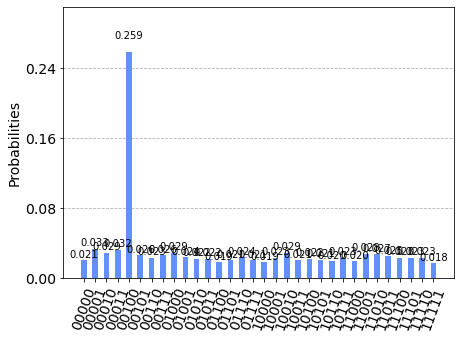

In [62]:
plot_histogram(result.circuit_results)